<a href="https://colab.research.google.com/github/MahanFathi/TrajOpt-KneedWalker/blob/main/trajopt_kneed_walker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limit Cycles for Passive Walker via Trajectory Optimization

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [ ]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

/content/jupyter_setup.py:13: UserWarning: jupyter_setup.py is deprecated.  Please use setup_underactuated_colab.py instead.
  warnings.warn("jupyter_setup.py is deprecated.  Please use"


Cloning into '/opt/underactuated'...

HEAD is now at 2a15bde minor reword on exercise 7.2 (#428)

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.0 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.






In [91]:
# others
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# drake
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq)

from underactuated import FindResource

## Problem Description
This trajectory optimization problem is somewhat different from other which you might have already encountered, in the sense that there are no control inputs and we're mainly after a set of stable initial conditions, which lead to stable gaits for the passive kneed walker. We use *Direct Collocation* method to solve for the trajectory. 

The state of the dynamical system consists of concatenation of the joint coordinates and the joint velocities, respectively denoted as $\mathbf{q}$ and $\mathbf{\dot{q}}$, i.e. $\mathbf{x} = [\mathbf{q}^T, \dot{\mathbf{q}}^T]^T$.

The Direct Collocation Method, despite Shooting Methods, treats the governing equations of motions as soft constraints by taking in the states and actions -- althogh here we have no control inputs -- at every timestep of the trajectory as optimization variables. 

## Parse the `urdf` and Get the `MultibodyPlant`

We start by defining a couple of physical parameters that we will need below.

In [92]:
# friction coefficient between feet and ground
friction = 10.0

# position of the feet in the respective leg frame
# (must match the urdf)
foot_in_leg = {
  "unlocked": {
    'stance_leg': np.zeros(3),        # stance foot in stance-leg frame
    'swing_thigh': np.array([0, 0, -0.5]), # knee in swing-thigh frame
    'swing_shin': np.array([0, 0, -0.5]) # swing foot in swing-shin frame
  },
  "locked": {
    'stance_leg': np.zeros(3),        # stance foot in stance-leg frame
    'swing_leg': np.array([0, 0, -1]) # swing foot in swing-leg framee
  }
}

These constants correspond to the physical properties of the walker, which are also reflected in the `urdf` files.

![kneedwalker](https://drive.google.com/uc?export=view&id=1GUt0ujaiFOIVFBd8HAhRTH8tbE1IiccG)

Image stolen from: 
[Vanessa Hsu, "Passive dynamic walking with knees: A Point-foot model", February, 2007.](http://groups.csail.mit.edu/robotics-center/public_papers/Hsu07.pdf)


In [93]:
l = 1
a1 = 0.375
b1 = 0.125
a2 = 0.175
b2 = 0.325
mh = 0.5
mt = 0.5
ms = 0.05
g = 1.0
ls = a1 + b1
lt = a2 + b2
gamma_slope = 0.0504
M = mt + ms
A = (ms * a1 + mt * (ls + a2)) / (mt + ms)
B = l - A

### `urdf` Definitions
We need to define our physical environment in `urdf` format, since this is how `drake` deals with all joints and math properties of a manipulator. 

In [94]:
urdf_knee_walker_unlocked = """
<?xml version="1.0" ?>

<robot name="kneed_walker_unlocked">

  <!-- ground -->
  <!-- just for visualization, it is welded to world -->

  <link name="ground">

    <visual>
      <origin xyz="0 0 -.25" rpy="0 0 0"/>
      <geometry>
        <box size="10 1 .5" />
      </geometry>
      <material name="green">
        <color rgba="0 1 0 1" />
      </material>
    </visual>

  </link>

  <joint name="ground_is_world" type="fixed">

    <parent link="world" />
    <child link="ground" />
    <!-- slope of the ramp here -->
    <origin xyz="0 0 0" rpy="0 .0504 0"/>

  </joint>

  <!-- floating base for stance foot -->

  <link name="floating_base_x" />

  <joint name="floating_base_x" type="prismatic">

    <parent link="ground"/>
    <child link="floating_base_x"/>
    <axis xyz="1 0 0"/>

  </joint>

  <link name="floating_base_z" />

  <joint name="floating_base_z" type="prismatic">

    <parent link="floating_base_x"/>
    <child link="floating_base_z"/>
    <axis xyz="0 0 1"/>

  </joint>

  <!-- stance leg -->

  <link name="stance_leg">

    <inertial>
      <origin xyz="0 0 .6477"/>
      <mass value=".55"/>
    </inertial>

    <visual>
      <origin xyz="0 0 .675"/>
      <geometry>
        <sphere radius=".075"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 .375"/>
      <geometry>
        <sphere radius=".015"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 .5"/>
      <geometry>
        <cylinder length="1" radius=".01"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

  </link>

  <joint name="floating_base_y" type="continuous">

    <parent link="floating_base_z"/>
    <child link="stance_leg"/>
    <axis xyz="0 -1 0"/>

  </joint>

  <!-- body, welded to stance leg -->

  <link name="body">

    <inertial>
      <origin xyz="0 0 0"/>
      <mass value="0.5"/>
    </inertial>

    <visual>
      <origin xyz="0 0 0"/>
      <geometry>
        <sphere radius=".075"/>
      </geometry>
      <material>
        <color rgba="1 1 1 1"/>
      </material>
    </visual>

  </link>

  <joint name="body_on_stance_leg" type="fixed">

    <parent link="stance_leg" />
    <child link="body" />
    <origin xyz="0 0 1"/>

  </joint>

  <!-- swing thigh -->

  <link name="swing_thigh">

    <inertial>
      <origin xyz="0 0 -.325"/>
      <mass value=".5"/>
    </inertial>

    <visual>
      <origin xyz="0 0 -.325"/>
      <geometry>
        <sphere radius=".075"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.25"/>
      <geometry>
        <cylinder length="0.5" radius=".01"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

  </link>

  <joint name="hip_pin" type="continuous">

    <parent link="body"/>
    <child link="swing_thigh"/>
    <axis xyz="0 -1 0"/>

  </joint>

  <!-- swing shin -->

  <link name="swing_shin">

    <inertial>
      <origin xyz="0 0 -.125"/>
      <mass value=".05"/>
    </inertial>

    <visual>
      <origin xyz="0 0 -.125"/>
      <geometry>
        <sphere radius=".015"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.25"/>
      <geometry>
        <cylinder length="0.5" radius=".01"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

  </link>

  <joint name="knee_pin" type="continuous">

    <parent link="swing_thigh"/>
    <child link="swing_shin"/>
    <axis xyz="0 -1 0"/>
    <origin xyz="0 0 -0.5"/>

  </joint>

</robot>
"""


urdf_knee_walker_locked = """
<?xml version="1.0" ?>

<!-- locked knee = compass gait -->
<robot name="kneed_walker_locked">

  <!-- ground -->
  <!-- just for visualization, it is welded to world -->

  <link name="ground">

    <visual>
      <origin xyz="0 0 -.25" rpy="0 0 0"/>
      <geometry>
        <box size="10 1 .5" />
      </geometry>
      <material name="green">
        <color rgba="0 1 0 1" />
      </material>
    </visual>

  </link>

  <joint name="ground_is_world" type="fixed">

    <parent link="world" />
    <child link="ground" />
    <!-- slope of the ramp here -->
    <origin xyz="0 0 0" rpy="0 .0504 0"/>

  </joint>

  <!-- floating base for stance foot -->

  <link name="floating_base_x" />

  <joint name="floating_base_x" type="prismatic">

    <parent link="ground"/>
    <child link="floating_base_x"/>
    <axis xyz="1 0 0"/>

  </joint>

  <link name="floating_base_z" />

  <joint name="floating_base_z" type="prismatic">

    <parent link="floating_base_x"/>
    <child link="floating_base_z"/>
    <axis xyz="0 0 1"/>

  </joint>

  <!-- stance leg -->

  <link name="stance_leg">

    <inertial>
      <origin xyz="0 0 .6477"/>
      <mass value=".55"/>
    </inertial>

    <visual>
      <origin xyz="0 0 .675"/>
      <geometry>
        <sphere radius=".075"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 .375"/>
      <geometry>
        <sphere radius=".015"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 .5"/>
      <geometry>
        <cylinder length="1" radius=".01"/>
      </geometry>
      <material>
        <color rgba="1 0 0 1"/>
      </material>
    </visual>

  </link>

  <joint name="floating_base_y" type="continuous">

    <parent link="floating_base_z"/>
    <child link="stance_leg"/>
    <axis xyz="0 -1 0"/>

  </joint>

  <!-- body, welded to stance leg -->

  <link name="body">

    <inertial>
      <origin xyz="0 0 0"/>
      <mass value="0.5"/>
    </inertial>

    <visual>
      <origin xyz="0 0 0"/>
      <geometry>
        <sphere radius=".075"/>
      </geometry>
      <material>
        <color rgba="1 1 1 1"/>
      </material>
    </visual>

  </link>

  <joint name="body_on_stance_leg" type="fixed">

    <parent link="stance_leg" />
    <child link="body" />
    <origin xyz="0 0 1"/>

  </joint>

  <!-- swing leg -->

  <link name="swing_leg">

    <inertial>
      <origin xyz="0 0 -.3523"/>
      <mass value=".55"/>
    </inertial>

    <visual>
      <origin xyz="0 0 -.325"/>
      <geometry>
        <sphere radius=".075"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.625"/>
      <geometry>
        <sphere radius=".015"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.5"/>
      <geometry>
        <cylinder length="1" radius=".01"/>
      </geometry>
      <material>
        <color rgba="0 0 1 1"/>
      </material>
    </visual>

  </link>

  <joint name="hip_pin" type="continuous">

    <parent link="body"/>
    <child link="swing_leg"/>
    <axis xyz="0 -1 0"/>

  </joint>

</robot>
"""

### Create MultibodyPlant

In [95]:
# parse urdf and create the MultibodyPlant
kneed_walker_unlocked = MultibodyPlant(time_step=0)
kneed_walker_locked = MultibodyPlant(time_step=0)
Parser(kneed_walker_unlocked).AddModelFromString(urdf_knee_walker_unlocked, file_type="urdf")
Parser(kneed_walker_locked).AddModelFromString(urdf_knee_walker_locked, file_type="urdf")
# use gravity to scale up the size of the robot
kneed_walker_unlocked.gravity_field().set_gravity_vector([0, 0, -.981])
kneed_walker_locked.gravity_field().set_gravity_vector([0, 0, -.981])
kneed_walker_unlocked.Finalize()
kneed_walker_locked.Finalize()

# overwrite MultibodyPlant with its autodiff copy
kneed_walker_unlocked = kneed_walker_unlocked.ToAutoDiffXd()
kneed_walker_locked = kneed_walker_locked.ToAutoDiffXd()

# number of configuration variables
nqu = kneed_walker_unlocked.num_positions()
nql = kneed_walker_locked.num_positions()

# number of components of the contact forces
nf = 2

## Defining Governing Dynamics


The trajectory optimization probelm is solved over the duration of a single step, which can be devided into two parts: 

- Taking the step with *unlocked* knee
- Landing the step with *locked* knee

Throughout the process, the stance foot has its knee locked. We also assume, the friction between the ground and feet is infinite (however, the we're able to find solutions for finite friction values), hence the stance foot acts as a pin joint with no slip. 

The equations of motion is consisted of 4 parts:
+ Unlocked Knee Dynamics
+ Knee Strike
+ Locked Knee Dynamics
+ Heel Strike

Knee strike is modeled via conservation of angular momentum around stance foot pin and the body, as an inelastic collision. Moreover, heel strike is modeled as impulsive collisio with a zero coefficient of restitution. One could also write down the equations of motion for the unlocked/locked knee phases using Lagrangian Mechanics, however, here `drake` provides the canonical manipulator equations in `MultibodyPlant` in differentiable form. 

In [96]:
from pydrake.math import cos, sin 

# Helper functions for kneestrike constraint
def kneestrike_f1(q, qd):
  return M * A ** 2 * qd[0] +  \
  mt * ( 
      -(-l * sin(q[0]) + b2 * sin(q[0] + q[1])) * (l * qd[0] * sin(q[0]) + b2 * qd[1] * sin(q[0] + q[1])) + \
      (l * cos(q[0]) - b2 * cos(q[0] + q[1])) * ( l * qd[0] * cos(q[0]) + b2 * qd[1] * cos(q[0] + q[1]) )) + \
      ms * (
        -(-l * sin(q[0]) + (l/2 + b1) * sin(q[0] + q[1])) * (l * qd[0] * sin(q[0]) + (l/2 * qd[1] + b1 * qd[2]) * sin(q[0] + q[1])) +
        ( l * cos(q[0]) - (l/2 + b1) * cos(q[0] + q[1]) ) * ( l * qd[0] * cos(q[0]) + (l/2 * qd[1] + b1 * qd[2]) * cos(q[0] + q[1])) )

def kneestrike_f2(q, qd):
  return mt * b2 ** 2 * qd[1] + ms * (l/2 + b1) * ( (l/2 + b1) * qd[1] + b1 * qd[2] )



In [97]:
import pydrake
from pydrake.math import cos, sin 

# Function that given the current configuration, velocity,
# acceleration, and contact force at the stance foot, evaluates
# the manipulator equations. The output of this function is a
# vector with dimensions equal to the number of configuration
# variables. If the output of this function is equal to zero
# then the given arguments verify the manipulator equations.
def manipulator_equations_unlocked_knee(vars):
    
    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nqu + nf
    split_at = [nqu, 2 * nqu, 3 * nqu]
    q, qd, qdd, f = np.split(vars, split_at)
    
    # set kneedwalker gait state
    context = kneed_walker_unlocked.CreateDefaultContext()
    kneed_walker_unlocked.SetPositions(context, q)
    kneed_walker_unlocked.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = kneed_walker_unlocked.CalcMassMatrixViaInverseDynamics(context)
    Cv = kneed_walker_unlocked.CalcBiasTerm(context)
    tauG = kneed_walker_unlocked.CalcGravityGeneralizedForces(context)
    
    # Jacobian of the stance foot
    J = get_foot_jacobian(kneed_walker_unlocked, context, 'stance_leg', foot_in_leg["unlocked"])
    
    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG - J.T.dot(f)

# repeating the above equation when the knee is locked
def manipulator_equations_locked_knee(vars):
    
    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nql + nf
    split_at = [nql, 2 * nql, 3 * nql]
    q, qd, qdd, f = np.split(vars, split_at)
    
    # set kneedwalker gait state
    context = kneed_walker_locked.CreateDefaultContext()
    kneed_walker_locked.SetPositions(context, q)
    kneed_walker_locked.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = kneed_walker_locked.CalcMassMatrixViaInverseDynamics(context)
    Cv = kneed_walker_locked.CalcBiasTerm(context)
    tauG = kneed_walker_locked.CalcGravityGeneralizedForces(context)
    
    # Jacobian of the stance foot
    J = get_foot_jacobian(kneed_walker_locked, context, 'stance_leg', foot_in_leg["locked"])
    
    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG - J.T.dot(f)

# Function that given the current configuration, returns
# the distance of the swing foot from the ground (scalar).
# We have penetration if the function output is negative.
def swing_foot_height(q):
    
    # get reference frames for the swing leg and the ground
    leg_frame = kneed_walker_unlocked.GetBodyByName('swing_shin').body_frame()
    ground_frame = kneed_walker_unlocked.GetBodyByName('ground').body_frame()
    
    # position of the swing foot in ground coordinates
    context = kneed_walker_unlocked.CreateDefaultContext()
    kneed_walker_unlocked.SetPositions(context, q)
    swing_foot_position = kneed_walker_unlocked.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg["unlocked"]['swing_shin'],
        ground_frame
    )
    
    # return only the coordinate z
    # (distance normal to the ground)
    return swing_foot_position[-1]

# Function that implements the impulsive collision. 
# Arguments are: compass gait configuration, velocities 
# before and after heel strike, and the swing-foot
# impulse (in latex, $\int_{t_c^-}^{t_c^+} \lambda dt$).
# Returns a vector of quantities that must vanish in order
# for the impulsive dynamics to be verified: it enforces the velocity
# jump due to the impulse, and the inelastic behavior of the
# collision (zero coefficient of restitution $e$).
def reset_velocity_heelstrike(vars):
    
    # split input vector in subvariables
    # qd_pre: generalized velocity before the heel strike
    # qd_post: generalized velocity after the heel strike
    # imp: swing-foot collision impulse (2d vector)
    assert vars.size == 3 * nql + nf
    split_at = [nql, 2 * nql, 3 * nql]
    q, qd_pre, qd_post, imp = np.split(vars, split_at)

    # set kneedwalker gait configuration
    context = kneed_walker_locked.CreateDefaultContext()
    kneed_walker_locked.SetPositions(context, q)
    
    # get necessary matrices
    M = kneed_walker_locked.CalcMassMatrixViaInverseDynamics(context)
    J = get_foot_jacobian(kneed_walker_locked, context, 'swing_leg', foot_in_leg["locked"])
    
    # return a vector that must vanish for the impulsive dynamics to hold
    return np.concatenate((
        M.dot(qd_post - qd_pre) - J.T.dot(imp), # velocity jump due to the impulse
        J.dot(qd_post)                          # zero velocity restitution
    ))

# Function that implements the angular momntum conservation
# during the kneestrike. Arguments are the configuration, 
# velocities, before and after the collision. The returned 
# contraints are enforced by setting to zero when adding the
# constraint to the mathematical program. 
def reset_velocity_kneestrike(vars):

    Nqu = 3
    Nql = 2
    assert vars.size == 2 * Nqu + Nql # q & qd before + qd after
    split_at = [Nqu, Nqu * 2]
    q, qdu, qdl = np.split(vars, split_at)

    constraints = np.zeros([2])
    constraints = pydrake.autodiffutils.initializeAutoDiff(constraints)

    constraints[0] = kneestrike_f1(q, qdu) - kneestrike_f1(q, [qdl[0], qdl[1], qdl[1]])
    constraints[1] = kneestrike_f2(q, qdu) - kneestrike_f2(q, [qdl[0], qdl[1], qdl[1]])

    return constraints

# Function that given a leg, returns the Jacobian matrix for the related foot.
def get_foot_jacobian(kneed_walker, context, leg, foot_in_leg):
    
    # get reference frames for the given leg and the ground
    leg_frame = kneed_walker.GetBodyByName(leg).body_frame()
    ground_frame = kneed_walker.GetBodyByName('ground').body_frame()

    # compute Jacobian matrix
    J = kneed_walker.CalcJacobianTranslationalVelocity(
        context,
        JacobianWrtVariable(0),
        leg_frame,
        foot_in_leg[leg],
        ground_frame,
        ground_frame
    )
    
    # discard y components since we are in 2D
    return J[[0, 2]]

## The Trajectory Optimization Problem

We start by setting some parameters of our optimization problem.

In [98]:
# time steps in the trajectory optimization
Tu = 60 # swing-leg unlocked
Tl = 30 # swing-leg locked
T = Tu + Tl

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

Below the decision variables of our porgram are defined. 

In [99]:
# initialize program
prog = MathematicalProgram()

# vector of the time intervals
# (distances between the T + 1 break points)
hu = prog.NewContinuousVariables(Tu, name='hu')
hl = prog.NewContinuousVariables(Tl, name='hl')

# system configuration, generalized velocities, and accelerations
# when knee is unlocked
qu = prog.NewContinuousVariables(rows=Tu+1, cols=nqu, name='qu')
qdu = prog.NewContinuousVariables(rows=Tu+1, cols=nqu, name='qdu')
qddu = prog.NewContinuousVariables(rows=Tu, cols=nqu, name='qddu')
# when knee is locked
ql = prog.NewContinuousVariables(rows=Tl+1, cols=nql, name='ql')
qdl = prog.NewContinuousVariables(rows=Tl+1, cols=nql, name='qdl')
qddl = prog.NewContinuousVariables(rows=Tl, cols=nql, name='qddl')

# angular velocities after heel strike
qd_post = prog.NewContinuousVariables(nql, name='qd_post')

# stance-foot force
fu = prog.NewContinuousVariables(rows=Tu, cols=nf, name='fu')
fl = prog.NewContinuousVariables(rows=Tl, cols=nf, name='fl')

# heel strike impulse for the swing leg
imp = prog.NewContinuousVariables(nf, name='imp')

## Constraints
As described above, the constraints correspond to the governing equations of motions and finding a stable limit cycle, in the sense that the walker's configuration/velocities are reset once it sets foot on the ground, so we can have an stable limit cycle. Note that the found solution is the fixed point of the step-to-step discrete function. We'll explore this discrete mapping in the Stability Analysis section. 

In [100]:
# lower and upper bound on the time steps for all t
prog.AddBoundingBoxConstraint([h_min] * Tu, [h_max] * Tu, hu)
prog.AddBoundingBoxConstraint([h_min] * Tl, [h_max] * Tl, hl)

# link the configurations, velocities, and accelerations
for t in range(Tl):
    prog.AddConstraint(eq(ql[t+1], ql[t] + hl[t] * qdl[t]))
    prog.AddConstraint(eq(qdl[t+1], qdl[t] + hl[t] * qddl[t]))

for t in range(Tu):
    prog.AddConstraint(eq(qu[t+1], qu[t] + hu[t] * qdu[t]))
    prog.AddConstraint(eq(qdu[t+1], qdu[t] + hu[t] * qddu[t]))

# manipulator equations for all t (implicit Euler)
for t in range(Tu-1):
    vars = np.concatenate((qu[t], qdu[t], qddu[t], fu[t]))
    prog.AddConstraint(manipulator_equations_unlocked_knee, lb=[0]*nqu, ub=[0]*nqu, vars=vars)
prog.AddConstraint(eq(qddu[-1], qddu[-2])) # jacobian has poor behavior at q3 = 0

for t in range(Tl):
    vars = np.concatenate((ql[t], qdl[t], qddl[t], fl[t]))
    prog.AddConstraint(manipulator_equations_locked_knee, lb=[0]*nql, ub=[0]*nql, vars=vars)

# knee strike constraints
# angular momentum conservation (qd)
vars = np.concatenate((qu[-1, 2:], qdu[-1, 2:], qdl[0, 2:]))
prog.AddConstraint(reset_velocity_kneestrike, lb=[0]*(nql-2), ub=[0]*(nql-2), vars=vars)
# leg and thigh are parallel
prog.AddLinearConstraint(qu[-1, 2+2] == 0)
# preserve joint coordinates
prog.AddLinearConstraint(qu[-1, 0+2] == ql[0, 0+2])
prog.AddLinearConstraint(qu[-1, 1+2] == ql[0, 1+2])


# heel strike constraints
# angular momentum conservation (qd)
vars = np.concatenate((ql[-1], qdl[-1], qd_post, imp))
prog.AddConstraint(reset_velocity_heelstrike, lb=[0]*(nql+nf), ub=[0]*(nql+nf), vars=vars)

# mirror initial and final configuration
prog.AddLinearConstraint(qu[0, 0+2] == -ql[-1, 0+2])
prog.AddLinearConstraint(qu[0, 1+2] == -ql[-1, 1+2])
prog.AddLinearConstraint(qu[0, 2+2] == 0)

# mirror constraint between initial and final velocity
prog.AddLinearConstraint(qdu[0, 0+2] == qd_post[2] + qd_post[3])
prog.AddLinearConstraint(qdu[0, 1+2] == - qd_post[3])
prog.AddLinearConstraint(qdu[0, 2+2] == 0)

# stance foot on the ground for all times
for t in range(Tu):
  prog.AddLinearConstraint(qu[t, 0] == 0)
  prog.AddLinearConstraint(qu[t, 1] == 0)
  prog.AddLinearConstraint(qdu[t, 0] == 0)
  prog.AddLinearConstraint(qdu[t, 1] == 0)
for t in range(Tl):
  prog.AddLinearConstraint(ql[t, 0] == 0)
  prog.AddLinearConstraint(ql[t, 1] == 0)
  prog.AddLinearConstraint(qdl[t, 0] == 0)
  prog.AddLinearConstraint(qdl[t, 1] == 0)

# swing foot on the ground at time zero
prog.AddLinearConstraint(qu[0, 0+2] == -qu[0,1+2] * 0.5)

# stance-foot contact force in friction cone for all times
for t in range(Tu):
  prog.AddLinearConstraint(fu[t, 1] >= 0)
  prog.AddLinearConstraint(-fu[t, 0] <= friction * fu[t, 1])
  prog.AddLinearConstraint(fu[t, 0] <= friction * fu[t, 1])
for t in range(Tl):
  prog.AddLinearConstraint(fl[t, 1] >= 0)
  prog.AddLinearConstraint(-fl[t, 0] <= friction * fl[t, 1])
  prog.AddLinearConstraint(fl[t, 0] <= friction * fl[t, 1])


# swing-foot impulse in friction cone
prog.AddLinearConstraint(imp[1] >= 0)
prog.AddLinearConstraint(-imp[0] <= friction * imp[1])
prog.AddLinearConstraint(imp[0] <= friction * imp[1])

# no penetration of the swing foot in the ground for all times
for t in range(Tu):
    prog.AddConstraint(swing_foot_height, lb=[0], ub=[np.inf], vars=qu[t])


A good initialization always makes things easier for the optimizer. 

In [101]:
# vector of the initial guess
initial_guess = np.zeros(prog.num_vars())

# initial guess for the time step
h_guess = h_max
prog.SetDecisionVariableValueInVector(hu, [h_guess] * Tu, initial_guess)
prog.SetDecisionVariableValueInVector(hl, [h_guess] * Tl, initial_guess)

# linear interpolation of the configuration
qu_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, Tu * h_guess / 2, Tu * h_guess],
    np.array([[.0, .0, .0], [.0, .0, .0], [.2, 0.0, -.15], [-.3, .0, .3], [0.0, -.14, 0.0]])
)
qdu_guess_poly = qu_guess_poly.derivative()
qddu_guess_poly = qu_guess_poly.derivative()

ql_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, Tl * h_guess],
    np.array([[.0, .0], [.0, .0], [-.15, -.2], [.3, .3]])
)
qdl_guess_poly = ql_guess_poly.derivative()
qddl_guess_poly = ql_guess_poly.derivative()

# set initial guess for configuration, velocity, and acceleration: unlocked
qu_guess = np.hstack([qu_guess_poly.value(t * h_guess) for t in range(Tu + 1)]).T
qdu_guess = np.hstack([qdu_guess_poly.value(t * h_guess) for t in range(Tu + 1)]).T
qddu_guess = np.hstack([qddu_guess_poly.value(t * h_guess) for t in range(Tu)]).T
prog.SetDecisionVariableValueInVector(qu, qu_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdu, qdu_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qddu, qddu_guess, initial_guess)


# set initial guess for configuration, velocity, and acceleration: locked
ql_guess = np.hstack([ql_guess_poly.value(t * h_guess) for t in range(Tl + 1)]).T
qdl_guess = np.hstack([qdl_guess_poly.value(t * h_guess) for t in range(Tl + 1)]).T
qddl_guess = np.hstack([qddl_guess_poly.value(t * h_guess) for t in range(Tl)]).T
prog.SetDecisionVariableValueInVector(ql, ql_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdl, qdl_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qddl, qddl_guess, initial_guess)


# initial guess for the normal component of the stance-leg force
bodies = ['body', 'stance_leg', 'swing_leg']
mass = sum(kneed_walker_locked.GetBodyByName(body).default_mass() for body in bodies)
g = - kneed_walker_locked.gravity_field().gravity_vector()[-1]
weight = mass * g
prog.SetDecisionVariableValueInVector(fu[:, 1], [weight] * Tu, initial_guess)
prog.SetDecisionVariableValueInVector(fl[:, 1], [weight] * Tl, initial_guess)

We can finally solve the problem! Be sure that the solver actually converged: you can check this by looking at the variable `result.is_success()` (printed below).

## Solve!

In [102]:
# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess)

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? True.


In the following cell we retrieve the optimal value of the decision variables and plot some results.

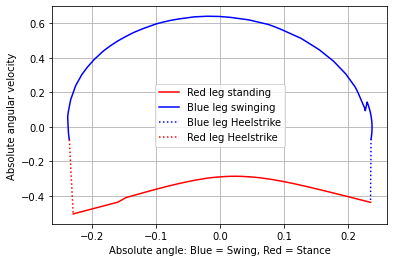

In [103]:
# retrieve the solution
hu_opt = result.GetSolution(hu)
hl_opt = result.GetSolution(hl)
qu_opt = result.GetSolution(qu)
qdu_opt = result.GetSolution(qdu)
qddu_opt = result.GetSolution(qddu)
ql_opt = result.GetSolution(ql)
qdl_opt = result.GetSolution(qdl)
qddl_opt = result.GetSolution(qddl)
fu_opt = result.GetSolution(fu)
fl_opt = result.GetSolution(fl)
imp_opt = result.GetSolution(imp)

# phase plot
# swing thigh
plt.plot(
    np.concatenate([qu_opt[:-1, 2], ql_opt[:-1, 2]]), 
    np.concatenate([qdu_opt[:-1, 2], qdl_opt[:-1, 2]]), 
    color='r', label='Red leg standing'
)
# stance foot
plt.plot(
    np.concatenate([qu_opt[:-1, 3] + qu_opt[:-1, 2], ql_opt[:-1, 3] + ql_opt[:-1, 2]]), 
    np.concatenate([qdu_opt[:-1, 3] + qdu_opt[:-1, 2], qdl_opt[:-1, 3] + qdl_opt[:-1, 2]]), 
    color='b', label='Blue leg swinging'
)

# heel strike velocity reset
plt.plot(
    [ql_opt[-2, 2] + ql_opt[-2, 3], qu_opt[0, 2]],
    [qdl_opt[-2, 2] + qdl_opt[-2, 3], qdu_opt[0, 2]],
    linestyle=':', color='b', label='Blue leg Heelstrike',
)
plt.plot(
    [qu_opt[0, 2] + qu_opt[0, 3], ql_opt[-2, 2]],
    [qdu_opt[0, 2] + qdu_opt[0, 3], qdl_opt[-2, 2]],
    linestyle=':', color='r', label='Red leg Heelstrike',
)
# misc options
plt.xlabel('Absolute angle: Blue = Swing, Red = Stance')
plt.ylabel('Absolute angular velocity')
plt.grid(True)
plt.legend()

## Animate the Result

Here we quickly build a Drake diagram to animate the result we got from trajectory optimization: useful for debugging your code and to be sure that everything looks good.

In [104]:
# stack states
ql_opt_ex = np.vstack([[ql[0], ql[1], ql[2], ql[3], 0] for ql in ql_opt])
qdl_opt_ex = np.vstack([[qdl[0], qdl[1], qdl[2], qdl[3], 0] for qdl in qdl_opt])
q_opt = np.vstack([qu_opt, ql_opt_ex])
qd_opt = np.vstack([qdu_opt, qdl_opt_ex])
x_opt = np.hstack((q_opt, qd_opt))

# interpolate state values for animation
time_breaks_opt_unlocked = np.array([sum(hu_opt[:t]) for t in range(Tu+1)])
time_breaks_opt_locked = np.array([sum(hl_opt[:t]) for t in range(Tl+1)])
time_breaks_opt_locked += max(time_breaks_opt_unlocked)
time_breaks_opt_locked[0] += 1e-7
time_breaks_opt = np.concatenate([time_breaks_opt_unlocked, time_breaks_opt_locked])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
kneed_walker_unlocked_vis = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
kneed_walker_unlocked_vis.RegisterAsSourceForSceneGraph(scene_graph)
Parser(kneed_walker_unlocked_vis).AddModelFromString(urdf_knee_walker_unlocked, file_type="urdf")
kneed_walker_unlocked_vis.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(kneed_walker_unlocked_vis, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(kneed_walker_unlocked_vis.get_source_id()))

# add visualizer
xlim = [-.75, 1.]
ylim = [-.2, 1.5]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

## Perturb Initial Conditions to get a Different Trajectory
Here we give the swing leg a tiny push to get a slightly different trajectory. This trajectory is more often reproduced among studies on the kneed walker.

In [105]:
# warmstart the initial guess with the solution
prog.SetDecisionVariableValueInVector(qu, qu_opt, initial_guess)
prog.SetDecisionVariableValueInVector(qdu, qdu_opt, initial_guess)
prog.SetDecisionVariableValueInVector(qddu, qddu_opt, initial_guess)
prog.SetDecisionVariableValueInVector(ql, ql_opt, initial_guess)
prog.SetDecisionVariableValueInVector(qdl, qdl_opt, initial_guess)
prog.SetDecisionVariableValueInVector(qddl, qddl_opt, initial_guess)
prog.SetDecisionVariableValueInVector(hu, hu_opt, initial_guess)
prog.SetDecisionVariableValueInVector(hl, hl_opt, initial_guess)
prog.SetDecisionVariableValueInVector(fu, fu_opt, initial_guess)
prog.SetDecisionVariableValueInVector(fl, fl_opt, initial_guess)
prog.SetDecisionVariableValueInVector(imp, imp_opt, initial_guess)

In [106]:
# basically repeat what we did so far
class KneedWalkerSolver(object):

  def __init__(self):
    self.result = None
    self.q_storage = []
    self.qd_storage = []


  def solve(self, q0, qd0):
    self._init_math_prog_and_vars()
    self._add_constraints(q0, qd0)
    # solve
    self.result = solver.Solve(self.prog, initial_guess)
    return self.result
  

  def get_last_stride_traj(self, ):
    qu_res = self.result.GetSolution(self.qu)
    qdu_res = self.result.GetSolution(self.qdu)
    ql_res = self.result.GetSolution(self.ql)
    qdl_res = self.result.GetSolution(self.qdl)
    ql_res_ex = np.vstack([np.append(ql, 0.0) for ql in ql_res])
    qdl_res_ex = np.vstack([[np.append(qdl, 0.0)] for qdl in qdl_res])

    q_res = np.vstack([qu_res, ql_res_ex])
    qd_res = np.vstack([qdu_res, qdl_res_ex])

    hu_res = self.result.GetSolution(self.hu)
    hl_res = self.result.GetSolution(self.hl)

    return q_res, qd_res, hu_res, hl_res
  
  
  def add_traj_to_storage(self, ):
    q_res, qd_res, _, _ = self.get_last_stride_traj()
    self.q_storage.append(q_res)
    self.qd_storage.append(qd_res)


  def get_new_init_cond(self, ):
    ql_res = self.result.GetSolution(self.ql)
    qdl_res = self.result.GetSolution(self.qdl)
    qd_post = self.result.GetSolution(self.qd_post)

    q0 = -np.append(ql_res[-1], 0.0)
    qd0 = np.zeros_like(q0)
    qd0[0+2] = qd_post[2] + qd_post[3]
    qd0[1+2] = -qd_post[3]

    self.q0 = q0
    self.qd0 = qd0
    
    return q0, qd0


  def _init_math_prog_and_vars(self, ):
    self.prog = MathematicalProgram()
    self.hu = self.prog.NewContinuousVariables(Tu, name='hu')
    self.hl = self.prog.NewContinuousVariables(Tl, name='hl')
    self.qu = self.prog.NewContinuousVariables(rows=Tu+1, cols=nqu, name='qu')
    self.qdu = self.prog.NewContinuousVariables(rows=Tu+1, cols=nqu, name='qdu')
    self.qddu = self.prog.NewContinuousVariables(rows=Tu, cols=nqu, name='qddu')
    self.ql = self.prog.NewContinuousVariables(rows=Tl+1, cols=nql, name='ql')
    self.qdl = self.prog.NewContinuousVariables(rows=Tl+1, cols=nql, name='qdl')
    self.qddl = self.prog.NewContinuousVariables(rows=Tl, cols=nql, name='qddl')
    self.qd_post = self.prog.NewContinuousVariables(nql, name='qd_post')
    self.fu = self.prog.NewContinuousVariables(rows=Tu, cols=nf, name='fu')
    self.fl = self.prog.NewContinuousVariables(rows=Tl, cols=nf, name='fl')
    self.imp = self.prog.NewContinuousVariables(nf, name='imp')


  def _add_constraints(self, q0, qd0):
    self.prog.AddConstraint(eq(self.qu[0], q0))
    self.prog.AddConstraint(eq(self.qdu[0], qd0))
    self.prog.AddBoundingBoxConstraint([h_min] * Tu, [h_max] * Tu, self.hu)
    self.prog.AddBoundingBoxConstraint([h_min] * Tl, [h_max] * Tl, self.hl)
    for t in range(Tl):
        self.prog.AddConstraint(eq(self.ql[t+1], self.ql[t] + self.hl[t] * self.qdl[t]))
        self.prog.AddConstraint(eq(self.qdl[t+1], self.qdl[t] + self.hl[t] * self.qddl[t]))
    for t in range(Tu):
        self.prog.AddConstraint(eq(self.qu[t+1], self.qu[t] + self.hu[t] * self.qdu[t]))
        self.prog.AddConstraint(eq(self.qdu[t+1], self.qdu[t] + self.hu[t] * self.qddu[t]))
    for t in range(Tu-1):
        vars = np.concatenate((self.qu[t], self.qdu[t], self.qddu[t], self.fu[t]))
        self.prog.AddConstraint(manipulator_equations_unlocked_knee, lb=[0]*nqu, ub=[0]*nqu, vars=vars)
    self.prog.AddConstraint(eq(self.qddu[-1], self.qddu[-2])) # jacobian has poor behavior at q3 = 0
    for t in range(Tl):
        vars = np.concatenate((self.ql[t], self.qdl[t], self.qddl[t], self.fl[t]))
        self.prog.AddConstraint(manipulator_equations_locked_knee, lb=[0]*nql, ub=[0]*nql, vars=vars)
    vars = np.concatenate((self.qu[-1, 2:], self.qdu[-1, 2:], self.qdl[0, 2:]))
    self.prog.AddConstraint(reset_velocity_kneestrike, lb=[0]*(nql-2), ub=[0]*(nql-2), vars=vars)
    self.prog.AddLinearConstraint(self.qu[-1, 2+2] == 0)
    self.prog.AddLinearConstraint(self.qu[-1, 0+2] == self.ql[0, 0+2])
    self.prog.AddLinearConstraint(self.qu[-1, 1+2] == self.ql[0, 1+2])
    vars = np.concatenate((self.ql[-1], self.qdl[-1], self.qd_post, self.imp))
    self.prog.AddConstraint(reset_velocity_heelstrike, lb=[0]*(nql+nf), ub=[0]*(nql+nf), vars=vars)
    # self.prog.AddLinearConstraint(self.qdu[0, 0+2] == self.qd_post[2] + self.qd_post[3])
    # self.prog.AddLinearConstraint(self.qdu[0, 1+2] == - self.qd_post[3])
    for t in range(Tu):
      self.prog.AddLinearConstraint(self.qu[t, 0] == 0)
      self.prog.AddLinearConstraint(self.qu[t, 1] == 0)
      self.prog.AddLinearConstraint(self.qdu[t, 0] == 0)
      self.prog.AddLinearConstraint(self.qdu[t, 1] == 0)
    for t in range(Tl):
      self.prog.AddLinearConstraint(self.ql[t, 0] == 0)
      self.prog.AddLinearConstraint(self.ql[t, 1] == 0)
      self.prog.AddLinearConstraint(self.qdl[t, 0] == 0)
      self.prog.AddLinearConstraint(self.qdl[t, 1] == 0)
    self.prog.AddLinearConstraint(self.ql[-1, 0+2] == -self.ql[-1,1+2] * 0.5)
    for t in range(Tu):
      self.prog.AddLinearConstraint(self.fu[t, 1] >= 0)
      self.prog.AddLinearConstraint(-self.fu[t, 0] <= friction * self.fu[t, 1])
      self.prog.AddLinearConstraint(self.fu[t, 0] <= friction * self.fu[t, 1])
    for t in range(Tl):
      self.prog.AddLinearConstraint(self.fl[t, 1] >= 0)
      self.prog.AddLinearConstraint(-self.fl[t, 0] <= friction * self.fl[t, 1])
      self.prog.AddLinearConstraint(self.fl[t, 0] <= friction * self.fl[t, 1])
    self.prog.AddLinearConstraint(self.imp[1] >= 0)
    self.prog.AddLinearConstraint(-self.imp[0] <= friction * self.imp[1])
    self.prog.AddLinearConstraint(self.imp[0] <= friction * self.imp[1])
    for t in range(Tu):
      self.prog.AddConstraint(swing_foot_height, lb=[0], ub=[np.inf], vars=self.qu[t])



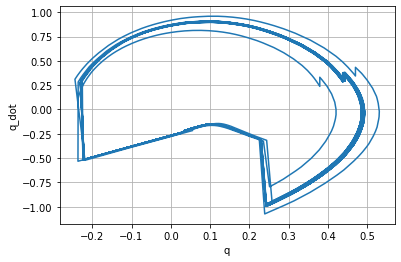

In [108]:
# Here we perturb the initial conditions to get a slightly different trajectory
q0 = q_opt[0]
qd0 = np.concatenate((qd_opt[0, :2], qd_opt[0, 2:4] + 0.1, qd_opt[0, -1:]))
kws = KneedWalkerSolver()
kws.solve(q0, qd0)
q_res, qd_res, hu_res, hl_res = kws.get_last_stride_traj() 
kws.add_traj_to_storage()

q_plot = q_res[:-1, 2] + q_res[:-1, 3]
qd_plot = qd_res[:-1, 2] + qd_res[:-1, 3]
for i in range(20):
  q0_new, qd0_new = kws.get_new_init_cond()
  kws.solve(q0_new, qd0_new)
  kws.add_traj_to_storage()
  q_res, qd_res, hu_res, hl_res = kws.get_last_stride_traj() 
  q_plot = np.concatenate([q_plot, q_res[:-1, 2], q_res[:-1, 2] + q_res[:-1, 3]])
  qd_plot = np.concatenate([qd_plot, qd_res[:-1, 2], qd_res[:-1, 2] + qd_res[:-1, 3]])

plt.plot(q_plot, qd_plot)
plt.xlabel('q')
plt.ylabel('q_dot')
plt.grid(True)

# store init conditions (they should be pretty close to fixed point)
q0, qd0 = kws.get_new_init_cond()


The above plot is for 20 steps of the walker. The walker continues takes 20 steps without falling to the ground. 

In [109]:
# stack states
x_opt = np.hstack((q_res, qd_res))

# interpolate state values for animation
time_breaks_opt_unlocked = np.array([sum(hu_res[:t]) for t in range(Tu+1)])
time_breaks_opt_locked = np.array([sum(hl_res[:t]) for t in range(Tl+1)])
time_breaks_opt_locked += max(time_breaks_opt_unlocked)
time_breaks_opt_locked[0] += 1e-7
time_breaks_opt = np.concatenate([time_breaks_opt_unlocked, time_breaks_opt_locked])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
kneed_walker_unlocked_vis = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
kneed_walker_unlocked_vis.RegisterAsSourceForSceneGraph(scene_graph)
Parser(kneed_walker_unlocked_vis).AddModelFromString(urdf_knee_walker_unlocked, file_type="urdf")
kneed_walker_unlocked_vis.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(kneed_walker_unlocked_vis, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(kneed_walker_unlocked_vis.get_source_id()))

# add visualizer
xlim = [-.75, 1.]
ylim = [-.2, 1.5]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

## Stability Analysis
Here we perturb the fixed point initial conditions to a dataset of mappings of different initial conditions. A linear model is fit to this data to approximate this discrete mapping. This function could be further investigated to analyze the stability of the limit cycle, using the method of Poincaré. 

$\mathbf{x_p[n+1] = P(x_p[n])}$

The above equation represent a Poincaré map for the walker where $\mathbf{x_p[n]}$ represents the initial conditions of the walker after taking $\mathbf{n}$ steps.

The linear approximation is as follows:

$\mathbf{(x_p[n+1] - x^*) = A (x_p[n] - x^*)}$

Where $\mathbf{x^*}$ is the fixed point to the Poincaré mapping function, $\mathbf{P}$.

Investigating the eigenvalues of matrix $\mathbf{A}$ reveals the stability properties of the limit cycle. 

In [110]:
def perturb_q(q_fix):
  ptb = 0.0001 * np.random.normal()
  return np.array([0, 0, q_fix[0+2] + ptb, q_fix[1+2] - 2 * ptb, q_fix[-1]])

def perturb_qd(qd_fix):
  ptb = 0.001 * np.random.normal(size=3)
  return np.concatenate([np.zeros(2), qd_fix[2:] + ptb])

In [111]:
# gather dataset
N = 50
X = []  # initial conditions
Y = []  # mapped to next inital condition 
# q0 = q_opt[0]
# qd0 = qd_opt[0]
kws = KneedWalkerSolver()
for _ in range(N):
  q0_ptb = perturb_q(q0)
  qd0_ptb = perturb_qd(qd0)
  X.append(np.concatenate([(q0_ptb - q0)[3:4], (qd0_ptb - qd0)[2:4]]))
  kws.solve(q0_ptb, qd0_ptb)
  q0_res, qd0_res = kws.get_new_init_cond()
  Y.append(np.concatenate([(q0_res - q0)[3:4], (qd0_res - qd0)[2:4]]))

X = np.vstack(X)
Y = np.vstack(Y)

# regression on data
A = np.transpose(np.linalg.pinv(X.T.dot(X)).dot(X.T.dot(Y)))

# get the eigenvalues
print(np.linalg.eigvals(A))


[-0.63033324+0.j          0.55391985+0.69130961j  0.55391985-0.69130961j]


Since all the magnitudes are within the unit circle, the system is locally stable.